In [1]:
import os
import sys
import getopt

import parse_genet
import vi

import importlib

import simulate
import torch
import matplotlib.pyplot as plt
import numpy as np

import pyro.distributions as dist

import scipy.stats

import pandas as pd
import numpy as np

import time

In [2]:
def check_sim_result(param_dict, title, chrom=22):
    if '1kg' in os.path.basename(param_dict['ref_dir']):
        ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_1kg_hm3')
    elif 'ukbb' in os.path.basename(param_dict['ref_dir']):
        ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_ukbb_hm3')

    ref_df = ref_df[ref_df.CHR == chrom]
    vld_df = parse_genet.parse_bim(param_dict['bim_prefix'] + ".bim")
    vld_df = vld_df[vld_df.CHR == chrom]
    sst_dict = parse_genet.parse_sumstats(ref_df, vld_df, param_dict['sst_file'], param_dict['n_gwas'])
    ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom)                                                                                                                                                                                 
    print("there are %d ld_blk" %(len(ld_blk)))

    beta_true, beta_mrg, annotations = simulate.simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], p = len(sst_dict))
    sst_dict["BETA"] = beta_mrg
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    importlib.reload(vi)
    one = torch.tensor(1., device=device)
    losses, beta, phi_est, stats = vi.vi(sst_dict, param_dict['n_gwas'], ld_blk, blk_size, device = device, annotations = annotations, max_iterations = param_dict['n_iter'], max_particles=4, desired_min_eig = 1e-3, min_iterations = 200, stall_window = 30, phi_as_prior = False, lr = 0.03, constrain_sigma = True)

    plt.plot(losses); plt.show()

    plt.scatter(beta_true, beta)
    plt.xlabel("True beta")
    plt.ylabel("Infered beta")
    plt.title("Pearson R=%1.3f" % scipy.stats.pearsonr(beta_true,beta)[0] )
    
    ## check anno
    anno_df = pd.DataFrame.from_dict(stats["annotation_weights"] )
    print(anno_df)
    anno_df.reset_index().plot(x="index", y = 'mean', yerr='std',kind="bar", color='lightskyblue', title = title, ylabel='weight', xlabel='annotation')
    print(stats["annotation_weights"]) # ideally should show large positive value for second entry, and close to 0 for third (noise)

    # convert standardized beta to per-allele beta
    if param_dict["beta_std"] == 'False':
        beta /= np.sqrt(2.0*sst_dict['MAF']*(1.0-sst_dict['MAF']))

    sst_dict["beta_shrunk"] = beta
    




[3, 34]


In [134]:
def check_sim_result_loop(param_dict, title, iteration = 5):
    if '1kg' in os.path.basename(param_dict['ref_dir']):
        ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_1kg_hm3')
    elif 'ukbb' in os.path.basename(param_dict['ref_dir']):
        ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_ukbb_hm3')

    ref_df = ref_df[ref_df.CHR == chrom]
    vld_df = parse_genet.parse_bim(param_dict['bim_prefix'] + ".bim")
    vld_df = vld_df[vld_df.CHR == chrom]
    sst_dict = parse_genet.parse_sumstats(ref_df, vld_df, param_dict['sst_file'], param_dict['n_gwas'])
    ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom)                                                                                                                                                                                 
    print("there are %d ld_blk" %(len(ld_blk)))
    
    pearsonr_list=[]
    anno_list=pd.DataFrame()

    for i in range(iteration):
        beta_true, beta_mrg, annotations = simulate.simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], p = len(sst_dict))
        sst_dict["BETA"] = beta_mrg
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        importlib.reload(vi)
        one = torch.tensor(1., device=device)
        losses, beta, phi_est, stats = vi.vi(sst_dict, param_dict['n_gwas'], ld_blk, blk_size, device = device, annotations = annotations, max_iterations = param_dict['n_iter'], max_particles=4, desired_min_eig = 1e-3, min_iterations = 200, stall_window = 30, phi_as_prior = False, lr = 0.03, constrain_sigma = True)
            
        plt.plot(losses); plt.show()
        r=scipy.stats.pearsonr(beta_true,beta)[0]
        pearsonr_list.append(r)

        ## check anno
        anno_df = pd.DataFrame.from_dict(stats["annotation_weights"] )
        print(anno_df)
        anno_list = anno_list.append(anno_df["mean"].to_frame().T, ignore_index=True)  
        
    ## plot anno  
    plt.bar(anno_list.mean().index, anno_list.mean(), yerr=anno_list.std(), capsize=10, color='turquoise')
    labels = ['intervel', 'perfect anno', 'random anno']
    plt.xticks(anno_list.mean().index, labels)
    plt.ylabel('weight')
    plt.title('iterate %d times'%(iteration))
    plt.show()
    
    print(stats["annotation_weights"]) # ideally should show large positive value for second entry, and close to 0 for third (noise)

    ## plot r
    plt.plot(range(iteration), pearsonr_list, marker='o', linestyle='--', color='c')
    
    ax = plt.axes()
    ax.set_ylim(0.5, 1)
    plt.xticks(list(range(iteration)),list(range(iteration)))
    plt.title('pearson r for betas')
    plt.show()

    print(pearsonr_list)
    return(anno_list,pearsonr_list)        
#     # convert standardized beta to per-allele beta
#     if param_dict["beta_std"] == 'False':
#         beta /= np.sqrt(2.0*sst_dict['MAF']*(1.0-sst_dict['MAF']))

#     sst_dict["beta_shrunk"] = beta
    




## Test of simulation data, only using chr22 from test data

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/sumstats.txt ...
... 991 common SNPs in the reference, sumstats, and validation set ...
... parse reference LD on chromosome 22 ...
there are 4 ld_blk
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 202 iterations. Increasing num_particles to 2.
Done after 127 iterations. Increasing num_particles to 4.
Done after 138 iterations. Increasing num_particles to 8.


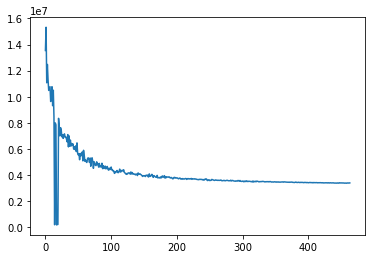

       mean       std        5%       95%
0  1.558509  0.145907  1.306454  1.791366
1  0.962018  0.148647  0.741711  1.187034
2 -0.132831  0.201178 -0.467998  0.188211
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 239 iterations. Increasing num_particles to 2.
Done after 67 iterations. Increasing num_particles to 4.
Done after 172 iterations. Increasing num_particles to 8.


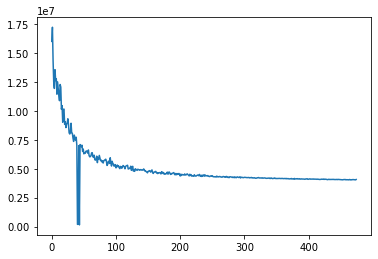

       mean       std        5%       95%
0  0.923575  0.299768  0.414109  1.330398
1  0.269896  0.308612 -0.247258  0.776182
2  0.852419  0.213065  0.481032  1.200091
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 212 iterations. Increasing num_particles to 2.
Done after 171 iterations. Increasing num_particles to 4.
Done after 110 iterations. Increasing num_particles to 8.


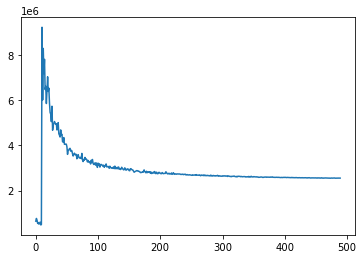

       mean       std        5%       95%
0 -1.154712  0.085966 -1.289150 -1.012341
1  0.453837  0.082308  0.315513  0.573296
2 -1.388511  0.086931 -1.558407 -1.231532
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 402 iterations. Increasing num_particles to 2.
Done after 89 iterations. Increasing num_particles to 4.
Done after 114 iterations. Increasing num_particles to 8.


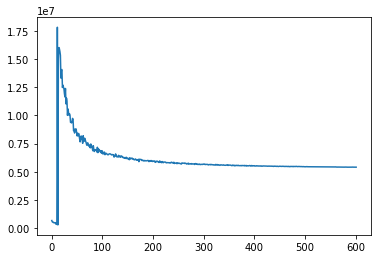

       mean       std        5%       95%
0  0.501563  0.092046  0.346270  0.643375
1  1.498573  0.079446  1.382906  1.643076
2 -0.718406  0.128969 -0.921800 -0.525665
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 257 iterations. Increasing num_particles to 2.
Done after 110 iterations. Increasing num_particles to 4.
Done after 106 iterations. Increasing num_particles to 8.


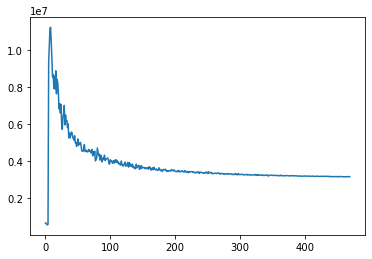

       mean       std        5%       95%
0  0.113497  0.103063 -0.050141  0.286173
1  0.392096  0.107039  0.210812  0.560778
2 -1.235465  0.091155 -1.383232 -1.100009
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 225 iterations. Increasing num_particles to 2.
Done after 199 iterations. Increasing num_particles to 4.
Done after 177 iterations. Increasing num_particles to 8.


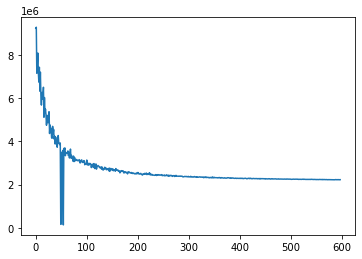

       mean       std        5%       95%
0  0.748208  0.246291  0.322588  1.105759
1  0.910354  0.396565  0.353043  1.527550
2 -1.053232  0.229291 -1.466735 -0.707732
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 359 iterations. Increasing num_particles to 2.
Done after 151 iterations. Increasing num_particles to 4.
Done after 148 iterations. Increasing num_particles to 8.


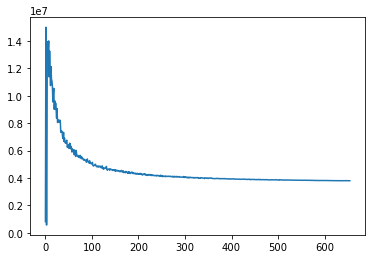

       mean       std        5%       95%
0 -0.772939  0.077680 -0.910880 -0.646643
1  2.160987  0.114329  1.974214  2.354386
2  1.228274  0.120978  1.039058  1.430202
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 296 iterations. Increasing num_particles to 2.
Done after 99 iterations. Increasing num_particles to 4.
Done after 128 iterations. Increasing num_particles to 8.


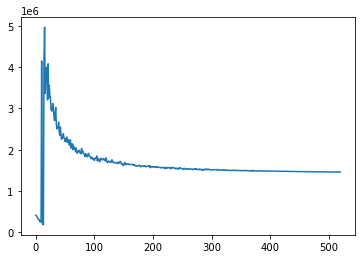

       mean       std        5%       95%
0  1.155202  0.094648  1.000407  1.321559
1  1.482959  0.086264  1.335953  1.596379
2 -0.072306  0.182993 -0.384178  0.204537
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 227 iterations. Increasing num_particles to 2.
Done after 133 iterations. Increasing num_particles to 4.
Done after 114 iterations. Increasing num_particles to 8.


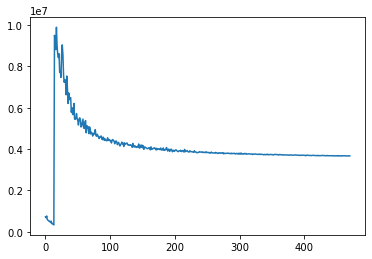

       mean       std        5%       95%
0  0.973780  0.174091  0.682977  1.218242
1 -1.059853  0.118007 -1.250899 -0.873423
2 -0.962467  0.110538 -1.149674 -0.820136
... SVI ...
Degenerate LD mat (min eigenvalue=-4.233e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 234 iterations. Increasing num_particles to 2.
Done after 151 iterations. Increasing num_particles to 4.
Done after 156 iterations. Increasing num_particles to 8.


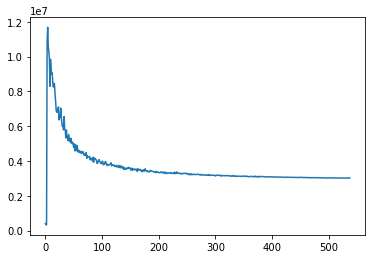

       mean       std        5%       95%
0  1.304015  0.091926  1.138057  1.468224
1  1.549430  0.087182  1.404418  1.684029
2 -0.480045  0.156308 -0.703865 -0.241313


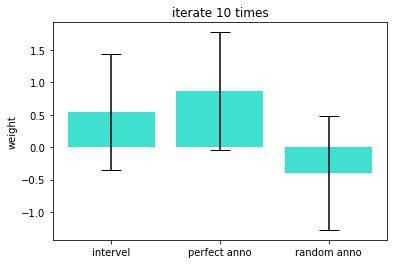

{'mean': tensor([ 1.3040,  1.5494, -0.4800]), 'std': tensor([0.0919, 0.0872, 0.1563]), '5%': tensor([ 1.1381,  1.4044, -0.7039]), '95%': tensor([ 1.4682,  1.6840, -0.2413])}


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


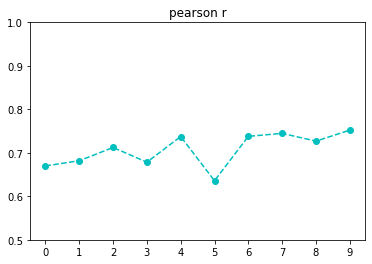

[0.6699252737867145, 0.6817366415061195, 0.7122644226024328, 0.6785080897600502, 0.7374209629468838, 0.6358918674486914, 0.7378732452719181, 0.7447379966052345, 0.7268784774228538, 0.7521735688955367]


In [132]:
chrom=22
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000
}

anno_test = check_sim_result_loop(param_dict, "sim 1000 SNPs in CHR22", iteration=10)

## 'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur' ## ukbb
## 'ref_dir' : "../ld/ldblk_1kg_eur", 
## 'bim_prefix' : "test_data/test",


In [133]:
anno_test[0]

,0,1,2
0,1.558509,0.962018,-0.132831
1,0.923575,0.269896,0.852419
2,-1.154712,0.453837,-1.388511
3,0.501563,1.498573,-0.718406
4,0.113497,0.392096,-1.235465
5,0.748208,0.910354,-1.053232
6,-0.772939,2.160987,1.228274
7,1.155202,1.482959,-0.072306
8,0.973780,-1.059853,-0.962467
9,1.304015,1.549430,-0.480045


In [4]:
## test the beta in sumstats
import pandas as pd
import numpy as np
sumstat = pd.read_csv('test_data/sumstats.txt', sep = '\t')
print(sumstat.BETA.mean(), sumstat.BETA.std())


-9.330000000000005e-05 0.012583713878063382


In [52]:
## testing only using 1000 SNPs in summary stats in chr22
# observations: 
# collapsed >> uncollapsed (deleted uncollapsed code)
# phi_as_prior = False seems to give better results, but phi_as_prior = True gives more robust training (less noisy loss), probably because constraint on psi is more useful. 
# Does constrain_sigma help? I think constrain_psi does. 
# Seem to need desired_min_eig=1e-3 at least to avoid numerical issues. Could go lower if using float64 it seemed. 


In [4]:
annotations.shape

torch.Size([991, 3])

In [5]:
stats["annotation_weights"] 

{'mean': tensor([ 1.5686,  0.1555, -0.7184]),
 'std': tensor([0.1330, 0.1174, 0.1177]),
 '5%': tensor([ 1.3670, -0.0415, -0.9147]),
 '95%': tensor([ 1.7798,  0.3482, -0.4920])}

In [84]:
ld_blk[1].shape ##(173,173)
blk_size ## [134, 173, 507, 177]
p ## the interception SNP of sumstat, ref_ld, validate df

ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom)

[134, 173, 507, 177]

In [87]:
stats["annotation_weights"] 

991

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14014 common SNPs in the reference, sumstats, and validation set ...
... parse reference LD on chromosome 22 ...
there are 24 ld_blk
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03


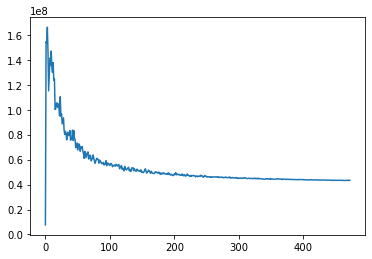

       mean       std        5%       95%
0 -0.455925  0.087000 -0.608210 -0.319303
1  0.717473  0.079256  0.551217  0.833432
2 -1.266708  0.108772 -1.454974 -1.113966
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

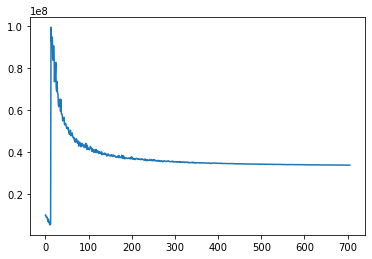

       mean       std        5%       95%
0 -0.650440  0.098642 -0.810978 -0.478541
1 -0.133448  0.083631 -0.275146 -0.003957
2  1.419999  0.071128  1.303378  1.535333
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

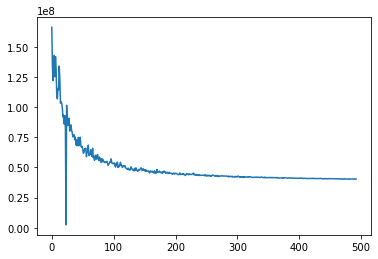

       mean       std        5%       95%
0  1.157213  0.164061  0.885079  1.399936
1  0.190127  0.176418 -0.108608  0.469435
2  0.832910  0.158211  0.584565  1.100665
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

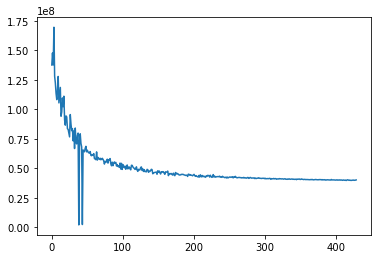

       mean       std        5%       95%
0  0.448358  0.302202 -0.062028  0.985891
1  0.242439  0.341661 -0.474328  0.742734
2  0.911534  0.220689  0.568360  1.257176
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

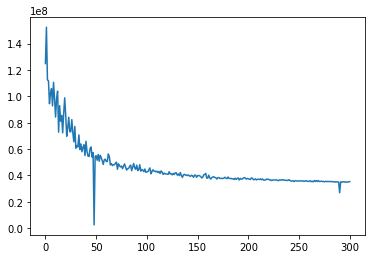

       mean       std        5%       95%
0  0.387550  0.256555 -0.102207  0.817071
1  0.877038  0.267554  0.375995  1.293593
2 -0.518689  0.368568 -1.162243  0.069663
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

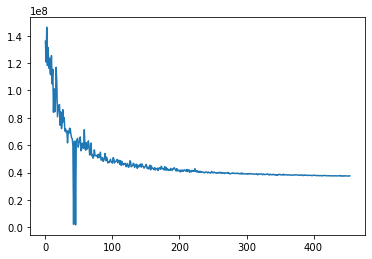

       mean       std        5%       95%
0  0.859656  0.281569  0.427253  1.323339
1  0.759933  0.230610  0.356285  1.152989
2  0.353156  0.312885 -0.167064  0.823504
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

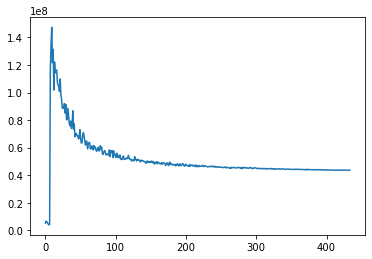

       mean       std        5%       95%
0  0.993982  0.097864  0.819816  1.148935
1  1.343361  0.136027  1.110945  1.533245
2 -0.526433  0.118832 -0.745339 -0.328228
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

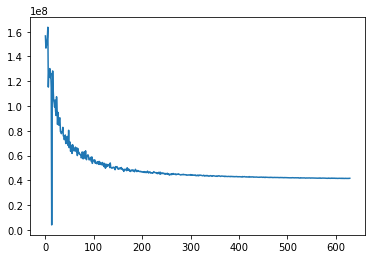

       mean       std        5%       95%
0  0.218754  0.170345 -0.047698  0.495845
1  0.042904  0.116386 -0.150176  0.224723
2 -0.954997  0.116400 -1.111843 -0.752040
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

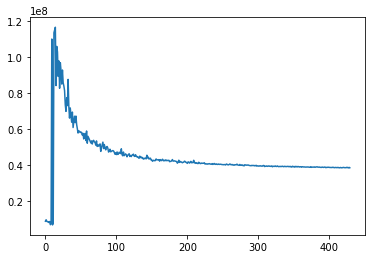

       mean       std        5%       95%
0 -0.944168  0.077141 -1.065274 -0.826210
1 -1.275051  0.130374 -1.492668 -1.067465
2  1.496700  0.107281  1.311948  1.670871
... SVI ...
Degenerate LD mat (min eigenvalue=-9.352e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.545e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.174e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.371e-02), fixing to 1.000e-03
Degenerate LD ma

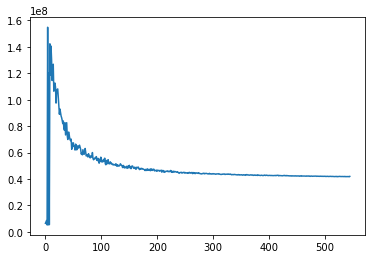

       mean       std        5%       95%
0 -0.203383  0.150384 -0.454674  0.036721
1  2.071481  0.075912  1.930627  2.204082
2 -0.773232  0.126027 -0.944816 -0.567115


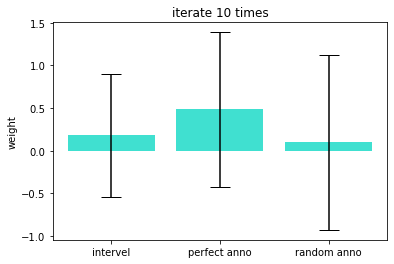

{'mean': tensor([-0.2034,  2.0715, -0.7732]), 'std': tensor([0.1504, 0.0759, 0.1260]), '5%': tensor([-0.4547,  1.9306, -0.9448]), '95%': tensor([ 0.0367,  2.2041, -0.5671])}


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


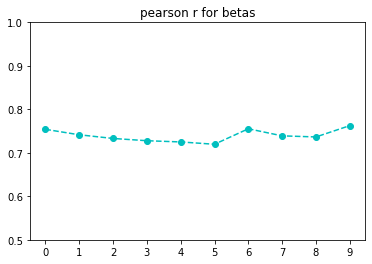

[0.7540347413419254, 0.7414992592807942, 0.7330411011572591, 0.7278447711594472, 0.7250157011890049, 0.7196752155753612, 0.7553155018153669, 0.739028726633243, 0.7365086723094462, 0.7625427005421034]


,0,1,2
0,-0.455925,0.717473,-1.266708
1,-0.650440,-0.133448,1.419999
2,1.157213,0.190127,0.832910
3,0.448358,0.242439,0.911534
4,0.387550,0.877038,-0.518689
5,0.859656,0.759933,0.353156
6,0.993982,1.343361,-0.526433
7,0.218754,0.042904,-0.954997
8,-0.944168,-1.275051,1.496700
9,-0.203383,2.071481,-0.773232


In [135]:
## using all chr22
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/ADSP_qc_chr22", 
    'sst_file' : "test_data/wightman_chr22.tsv", 
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000
}
anno_test = check_sim_result_loop(param_dict, "all SNPs in CHR22", iteration=10)

anno_test[0]

{'mean': tensor([-0.2933, -0.4109, -1.0899]),
 'std': tensor([0.1122, 0.0975, 0.1078]),
 '5%': tensor([-0.4841, -0.5729, -1.2910]),
 '95%': tensor([-0.1107, -0.2646, -0.9305])}

In [20]:
loss_np = np.array(losses)
indices = np.where(loss_np < 1e7)[0]

# Print values and their corresponding indices
for index in indices:
    print(f"Value {loss_np[index]} at index {index}")

Value 2530739.7761394978 at index 56
Value 2474466.6801837683 at index 60
Value 1457925.2138929367 at index 141


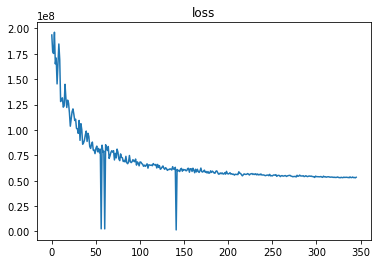

In [22]:
plt.plot(losses); plt.title('loss');plt.show()

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_1kg_eur/snpinfo_1kg_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14130 common SNPs in the reference, sumstats, and validation set ...
... parse reference LD on chromosome 22 ...
there are 24 ld_blk
... SVI ...
Degenerate LD mat (min eigenvalue=-3.739e-07), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-7.873e-07), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.630e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.276e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.458e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.766e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-4.344e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.486e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-4.003e-06), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.808e-06), fixing to 1.000e-03
De

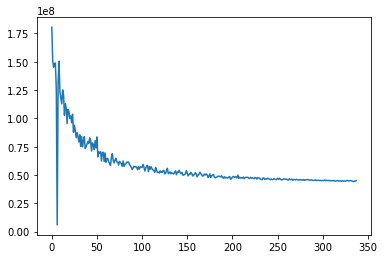

       mean       std        5%       95%
0  0.134044  0.096270 -0.014506  0.307582
1  0.401788  0.113878  0.211145  0.561761
2 -1.153563  0.106468 -1.318990 -1.005556
{'mean': tensor([ 0.1340,  0.4018, -1.1536]), 'std': tensor([0.0963, 0.1139, 0.1065]), '5%': tensor([-0.0145,  0.2111, -1.3190]), '95%': tensor([ 0.3076,  0.5618, -1.0056])}


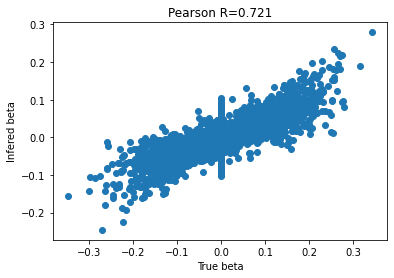

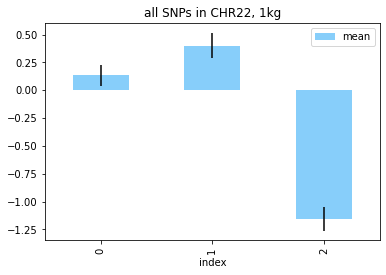

In [40]:
## using all chr22 ## 1kg
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_1kg_eur', ## add my path
    'bim_prefix' : "test_data/ADSP_qc_chr22", 
    'sst_file' : "test_data/wightman_chr22.tsv", 
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000
}

check_sim_result(param_dict, "all SNPs in CHR22, 1kg")


## testing to make the first anno 100% accurate

<AxesSubplot:title={'center':'title'}, xlabel='annotation', ylabel='weight'>

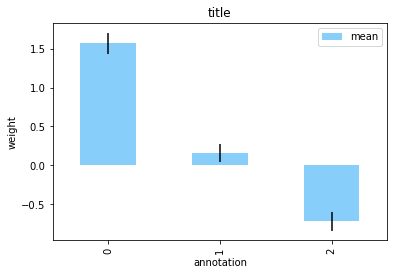

In [45]:
anno_df.reset_index().plot(x="index", y = 'mean', yerr='std',kind="bar", color='lightskyblue', title = 'title', ylabel='weight', xlabel='annotation')